## 1. Generation

### 1.1 Device configuation

In [7]:
device = "cuda"

### 1.2 Load model

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)

### 1.3 Configure prediction

In [9]:
max_length = 25
input_string = "When my flight landed in Thailand. I was staying in the capital city of"

### 1.4 Run prediction

In [10]:
import torch

input_ids = tokenizer(input_string, return_tensors='pt')['input_ids'][0].to(model.device)
generated_ids = model.generate(input_ids=torch.unsqueeze(input_ids, 0), max_length=max_length, do_sample=False)[0]
generated_texts = [ tokenizer.decode(token) for token in generated_ids ]
print(f'generated full sequence --> {generated_texts}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


generated full sequence --> ['When', ' my', ' flight', ' landed', ' in', ' Thailand', '.', ' I', ' was', ' staying', ' in', ' the', ' capital', ' city', ' of', ' Bangkok', '.', ' I', ' was', ' in', ' a', ' hotel', ' room', ' with', ' my']


## 2. Rationalization

### 2.1 Construct rationalizer

In [11]:
from rationalization.rationalizer.aggregate_rationalizer import AggregateRationalizer
from rationalization.rationalizer.importance_score_evaluator.delta_prob import DeltaProbImportanceScoreEvaluator
from rationalization.rationalizer.stopping_condition_evaluator.top_k import TopKStoppingConditionEvaluator
from rationalization.rationalizer.token_replacement.token_replacer.uniform import UniformTokenReplacer
from rationalization.rationalizer.token_replacement.token_sampler.postag import POSTagTokenSampler

rational_size = 5
rational_size_ratio = None

token_sampler = POSTagTokenSampler(tokenizer=tokenizer, device=device)

stopping_condition_evaluator = TopKStoppingConditionEvaluator(
    model=model, 
    token_sampler=token_sampler, 
    top_k=10, 
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio, 
    tokenizer=tokenizer
)

importance_score_evaluator = DeltaProbImportanceScoreEvaluator(
    model=model, 
    tokenizer=tokenizer, 
    token_replacer=UniformTokenReplacer(
        token_sampler=token_sampler, 
        ratio=0.3
    ),
    stopping_condition_evaluator=stopping_condition_evaluator,
    max_steps=3000
)

rationalizer = AggregateRationalizer(
    importance_score_evaluator=importance_score_evaluator,
    batch_size=5,
    overlap_threshold=2,
    overlap_strict_pos=True,
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio
)

[POSTagTokenSampler] Loading vocab from tokenizer - 0.00%
[POSTagTokenSampler] Loading vocab from tokenizer - 9.95%
[POSTagTokenSampler] Loading vocab from tokenizer - 19.90%
[POSTagTokenSampler] Loading vocab from tokenizer - 29.85%
[POSTagTokenSampler] Loading vocab from tokenizer - 39.80%
[POSTagTokenSampler] Loading vocab from tokenizer - 49.74%
[POSTagTokenSampler] Loading vocab from tokenizer - 59.69%
[POSTagTokenSampler] Loading vocab from tokenizer - 69.64%
[POSTagTokenSampler] Loading vocab from tokenizer - 79.59%
[POSTagTokenSampler] Loading vocab from tokenizer - 89.54%
[POSTagTokenSampler] Loading vocab from tokenizer - 99.49%


### 2.2 Run rationalization

In [12]:
# rationalize each generated token

importance_scores = []
importance_score_map = torch.zeros([generated_ids.shape[0] - input_ids.shape[0], generated_ids.shape[0] - 1], device=device)

for target_pos in torch.arange(input_ids.shape[0], generated_ids.shape[0]):
    
    # extract target
    target_id = generated_ids[target_pos]

    # rationalization
    pos_rational = rationalizer.rationalize(torch.unsqueeze(generated_ids[:target_pos], 0), torch.unsqueeze(target_id, 0))[0]

    ids_rational = generated_ids[pos_rational]
    text_rational = [ tokenizer.decode([id_rational]) for id_rational in ids_rational ]

    importance_score_map[target_pos - input_ids.shape[0], :target_pos] = rationalizer.mean_important_score

    print(f'{target_pos + 1} / {generated_ids.shape[0]}')
    print(f'Target word     --> {tokenizer.decode(target_id)}', )
    print(f"Rational pos    --> {pos_rational}")
    print(f"Rational text   --> {text_rational}")

    print()

16 / 25
Target word     -->  Bangkok
Rational pos    --> tensor([ 5,  7, 11, 12, 13, 14], device='cuda:0')
Rational text   --> [' Thailand', ' I', ' the', ' capital', ' city', ' of']

17 / 25
Target word     --> .
Rational pos    --> tensor([ 0,  1,  8, 10, 11, 13, 15], device='cuda:0')
Rational text   --> ['When', ' my', ' was', ' in', ' the', ' city', ' Bangkok']

18 / 25
Target word     -->  I
Rational pos    --> tensor([ 0,  2,  4,  7,  9, 11, 15], device='cuda:0')
Rational text   --> ['When', ' flight', ' in', ' I', ' staying', ' the', ' Bangkok']

19 / 25
Target word     -->  was
Rational pos    --> tensor([ 0,  1,  5,  7, 11, 13, 17], device='cuda:0')
Rational text   --> ['When', ' my', ' Thailand', ' I', ' the', ' city', ' I']

20 / 25
Target word     -->  in
Rational pos    --> tensor([ 0,  4,  5,  6,  9, 11, 17], device='cuda:0')
Rational text   --> ['When', ' in', ' Thailand', '.', ' staying', ' the', ' I']

21 / 25
Target word     -->  a
Rational pos    --> tensor([ 1,  2, 

### 2.3 Visualize rationalization results

<AxesSubplot:xlabel='Importance distribution', ylabel='Target'>

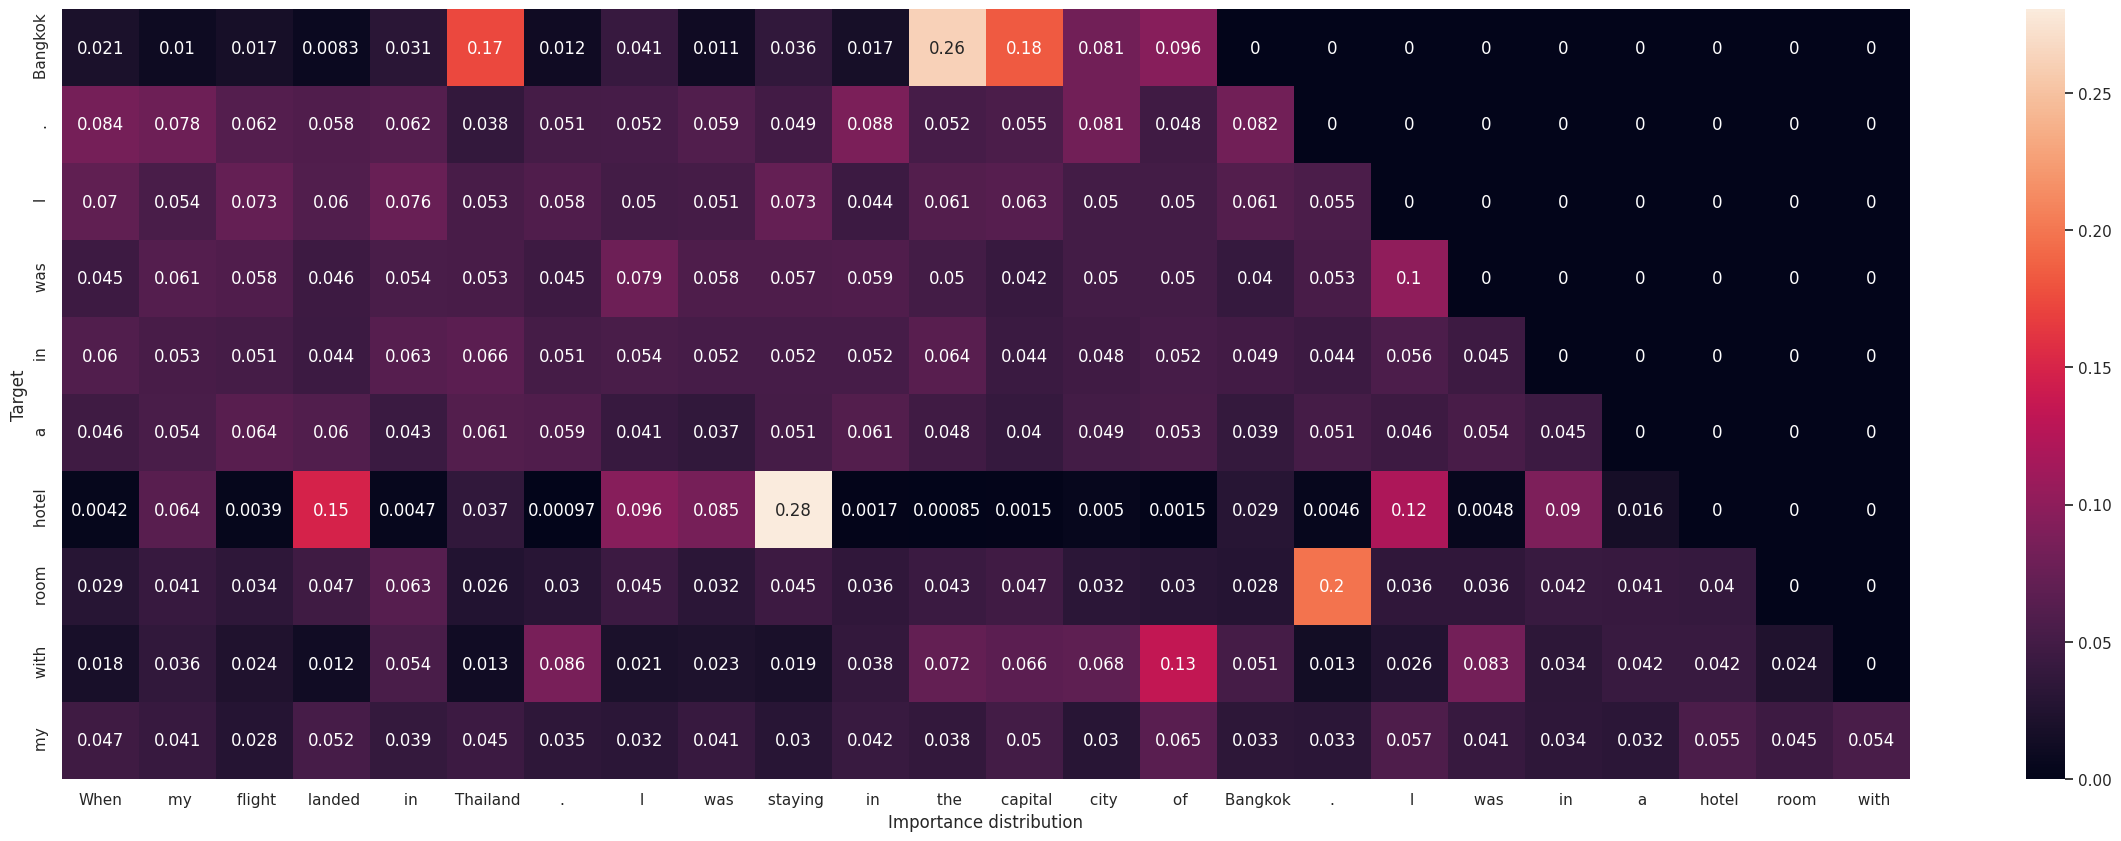

In [13]:
import seaborn
seaborn.set(rc={ 'figure.figsize': (30, 10) })
s = seaborn.heatmap(
    importance_score_map.cpu(), 
    xticklabels=generated_texts[:-1], 
    yticklabels=generated_texts[input_ids.shape[0]:], 
    annot=True, 
    square=True)
s.set_xlabel('Importance distribution')
s.set_ylabel('Target')
s

## 3. Evaluation

### 3.1 Configure evaluation

In [14]:
metric_stride = 2

### 3.2 Compute metrics

In [20]:
from evaluation.evaluator.soft_norm_sufficiency import SoftNormalizedSufficiencyEvaluator
from evaluation.evaluator.soft_norm_comprehensiveness import SoftNormalizedComprehensivenessEvaluator
soft_norm_suff_evaluator = SoftNormalizedSufficiencyEvaluator(model)
soft_norm_comp_evaluator = SoftNormalizedComprehensivenessEvaluator(model)

norm_suff_all = []
norm_comp_all = []
target_token_all = []

table_details = [ ["target_pos", "target_token", "norm_suff", "norm_comp"] ]

for target_pos in torch.arange(input_ids.shape[0], generated_ids.shape[0], metric_stride):

    target_token = tokenizer.decode(generated_ids[target_pos])
    target_token_all.append(target_token)

    input_ids_step = torch.unsqueeze(generated_ids[:target_pos], 0)
    target_id_step = torch.unsqueeze(generated_ids[target_pos], 0)
    importance_score_step = torch.unsqueeze(importance_score_map[target_pos - input_ids.shape[0], :target_pos], 0)

    norm_suff = soft_norm_suff_evaluator.evaluate(input_ids_step, target_id_step, importance_score_step)
    norm_suff_all.append(norm_suff)

    norm_comp = soft_norm_comp_evaluator.evaluate(input_ids_step, target_id_step, importance_score_step)
    norm_comp_all.append(norm_comp)

    table_details.append([target_pos.item() + 1, target_token, norm_suff.item(), norm_comp.item()])
    print(f"target_pos: {target_pos + 1}, target_token: {target_token}, norm_suff: {norm_suff}, norm_comp: {norm_comp}")

norm_suff_mean = torch.mean(torch.tensor(norm_suff_all, device=device))
norm_comp_mean = torch.mean(torch.tensor(norm_comp_all, device=device))

print(f"norm_suff_mean: {norm_suff_mean}, norm_comp_mean: {norm_comp_mean}")

target_pos: 16, target_token:  Bangkok, norm_suff: 0.0, norm_comp: 0.055724624544382095
target_pos: 18, target_token:  I, norm_suff: 0.0011335751041769981, norm_comp: 0.08005993813276291
target_pos: 20, target_token:  in, norm_suff: 0.0010249933693557978, norm_comp: 0.07356485724449158
target_pos: 22, target_token:  hotel, norm_suff: 0.0, norm_comp: 0.04137211665511131
target_pos: 24, target_token:  with, norm_suff: 0.0, norm_comp: 0.022249441593885422
norm_suff_mean: 0.00043171370634809136, norm_comp_mean: 0.05459419637918472


### 3.3 Show metrics in tables

In [21]:
import tabulate
from IPython.display import HTML, display

table_details_html = tabulate.tabulate(table_details, tablefmt='html')

display(HTML(table_details_html))

table_mean = [
        [ "target_tokens", "norm_suff_mean", "norm_comp_mean" ],
        [ "$".join(target_token_all), norm_suff_mean.item(), norm_comp_mean.item() ]
    ]

table_mean_html = tabulate.tabulate(table_mean, tablefmt='html')

display(HTML(table_mean_html))

target_pos,target_token,norm_suff,norm_comp
16,Bangkok,0.0,0.055724624544382095
18,I,0.0011335751041769981,0.08005993813276291
20,in,0.0010249933693557978,0.07356485724449158
22,hotel,0.0,0.04137211665511131
24,with,0.0,0.022249441593885422


target_tokens,norm_suff_mean,norm_comp_mean
Bangkok$ I$ in$ hotel$ with,0.00043171370634809136,0.05459419637918472


### 3.4 Save results to file

In [22]:
import csv

with open('notebook_details.csv', 'w', newline='') as csvfile:
    csvWriter = csv.writer(csvfile)
    csvWriter.writerows(table_details)

with open('notebook_mean.csv', 'w', newline='') as csvfile:
    csvWriter = csv.writer(csvfile)
    csvWriter.writerows(table_mean)